### Library Import

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("..")

from src.sanity import *

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

### Load dataset 

In [3]:
from src.load_datasets import load_traffic_data


dataframe = (
    load_traffic_data()
    .pipe(
        select_column,
        cols=[
            "date_time",
            "temp",
            "rain_1h",
            "snow_1h",
            "clouds_all",
            "traffic_volume",
        ],
    )
    .pipe(format_datetime, col="date_time")
    .pipe(set_index, col="date_time")
    .pipe(resample_data, freq="H")
    .pipe(interpolate_column)
)

print(f"dataframe shape {dataframe.shape}")

dataframe.head()

select_column: DF Shape (48204, 6)
format_datetime: DF Shape (48204, 6)
set_index: DF Shape (48204, 5)
resample_Data: DF Shape (52551, 5)
interpolate_columns: DF Shape (52551, 5)
dataframe shape (52551, 5)


,temp,rain_1h,snow_1h,clouds_all,traffic_volume
date_time,,,,,
2012-10-02 09:00:00,288.28,0.0,0.0,40.0,5545.0
2012-10-02 10:00:00,289.36,0.0,0.0,75.0,4516.0
2012-10-02 11:00:00,289.58,0.0,0.0,90.0,4767.0
2012-10-02 12:00:00,290.13,0.0,0.0,90.0,5026.0
2012-10-02 13:00:00,291.14,0.0,0.0,75.0,4918.0


In [4]:
dataframe.isna().sum()

temp              0
rain_1h           0
snow_1h           0
clouds_all        0
traffic_volume    0
dtype: int64

In [5]:
# dataframe.info()
# dataframe.isna().sum()
corr = dataframe.corr()
corr.style.background_gradient(cmap="coolwarm")

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
temp,1.000000,0.007676,-0.018574,-0.032577,0.131058
rain_1h,0.007676,1.000000,-0.000059,0.003462,0.005204
snow_1h,-0.018574,-0.000059,1.000000,0.021784,0.001282
clouds_all,-0.032577,0.003462,0.021784,1.000000,0.024472
traffic_volume,0.131058,0.005204,0.001282,0.024472,1.000000


### Test Train split

train_xy and test_xy size: (52521, 5), (30, 5)

y_train and x_train size (52521,), (52521, 4)
y_test  and x_test  size (30,),  (30, 4)



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='traffic_volume'>)

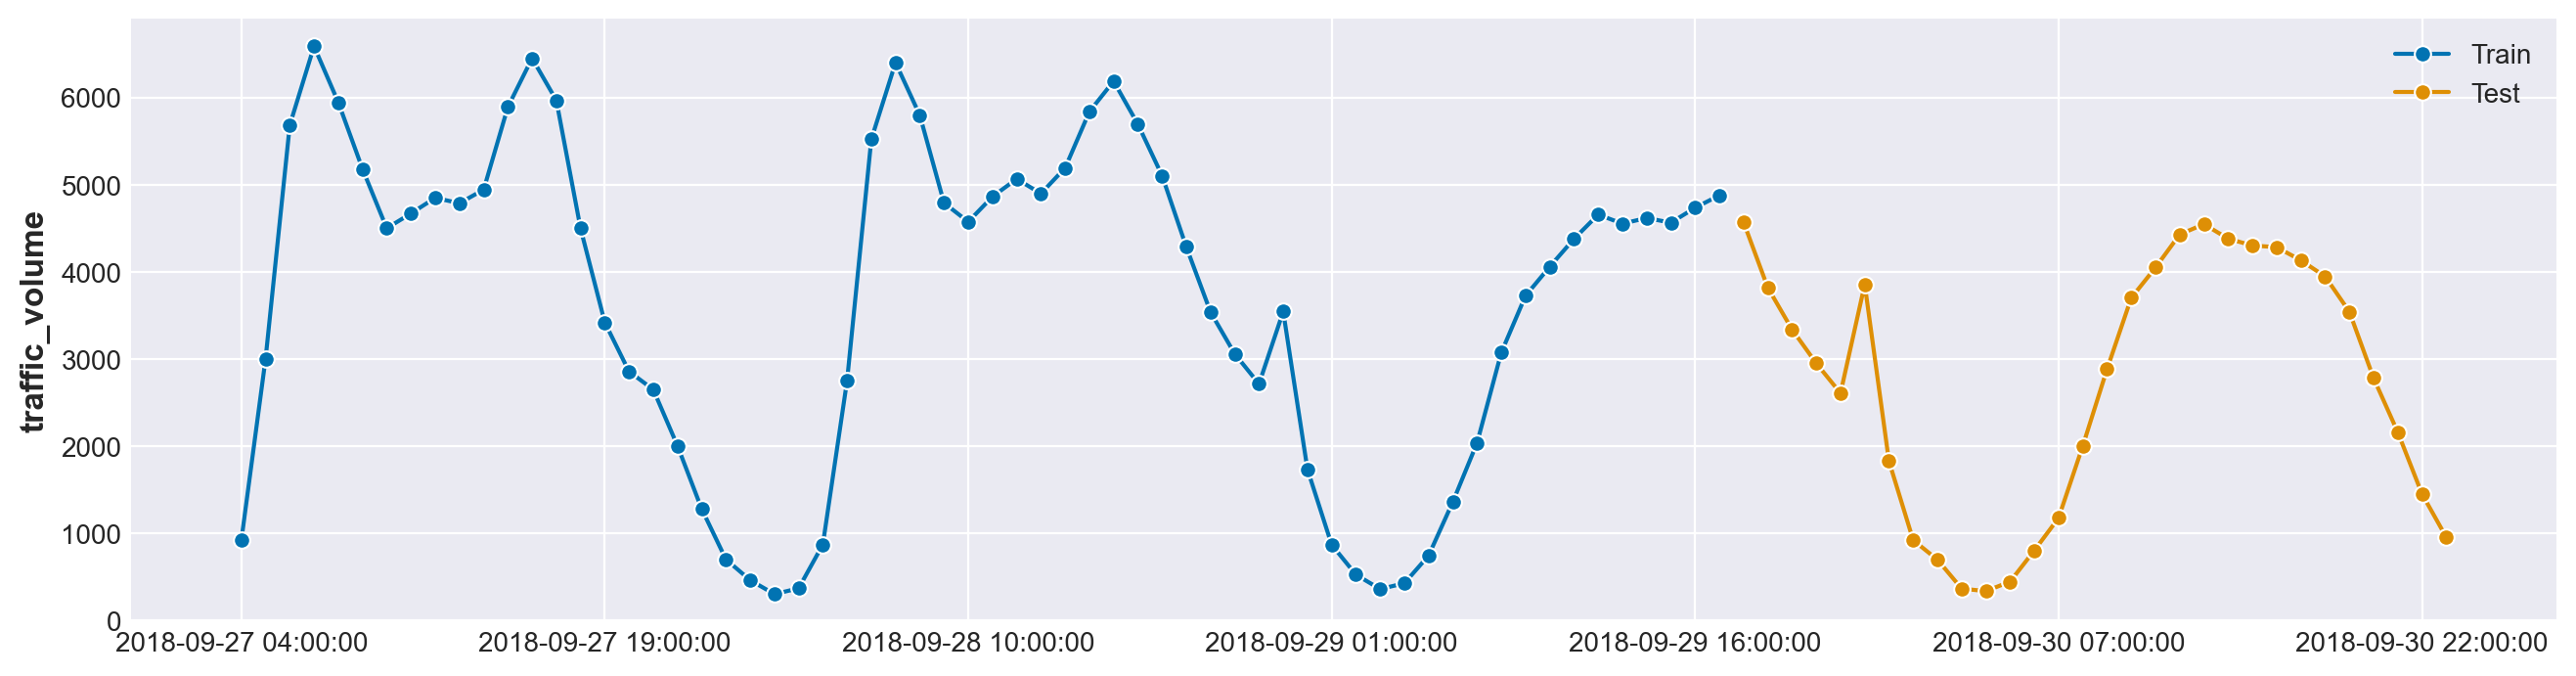

In [6]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

TEST_SIZE = 15
TARGET_COl = "traffic_volume"

train_xy, test_xy = temporal_train_test_split(dataframe, test_size=2 * TEST_SIZE)

print(f"train_xy and test_xy size: {train_xy.shape}, {test_xy.shape}", end="\n\n")

y_train = train_xy[TARGET_COl].copy(deep=True)
x_train = train_xy.drop(columns=[TARGET_COl]).copy(deep=True)

y_test = test_xy[TARGET_COl].copy(deep=True)
x_test = test_xy.drop(columns=[TARGET_COl]).copy(deep=True)

print(f"y_train and x_train size {y_train.shape}, {x_train.shape}")
print(
    f"y_test  and x_test  size {y_test.shape},  {x_test.shape}",
    end="\n\n",
)

plot_series(y_train.tail(62), y_test, labels=["Train", "Test"])

#### Huyper Parameter Selection 

intital_window_size 52446 , step_length 15 for fold 5


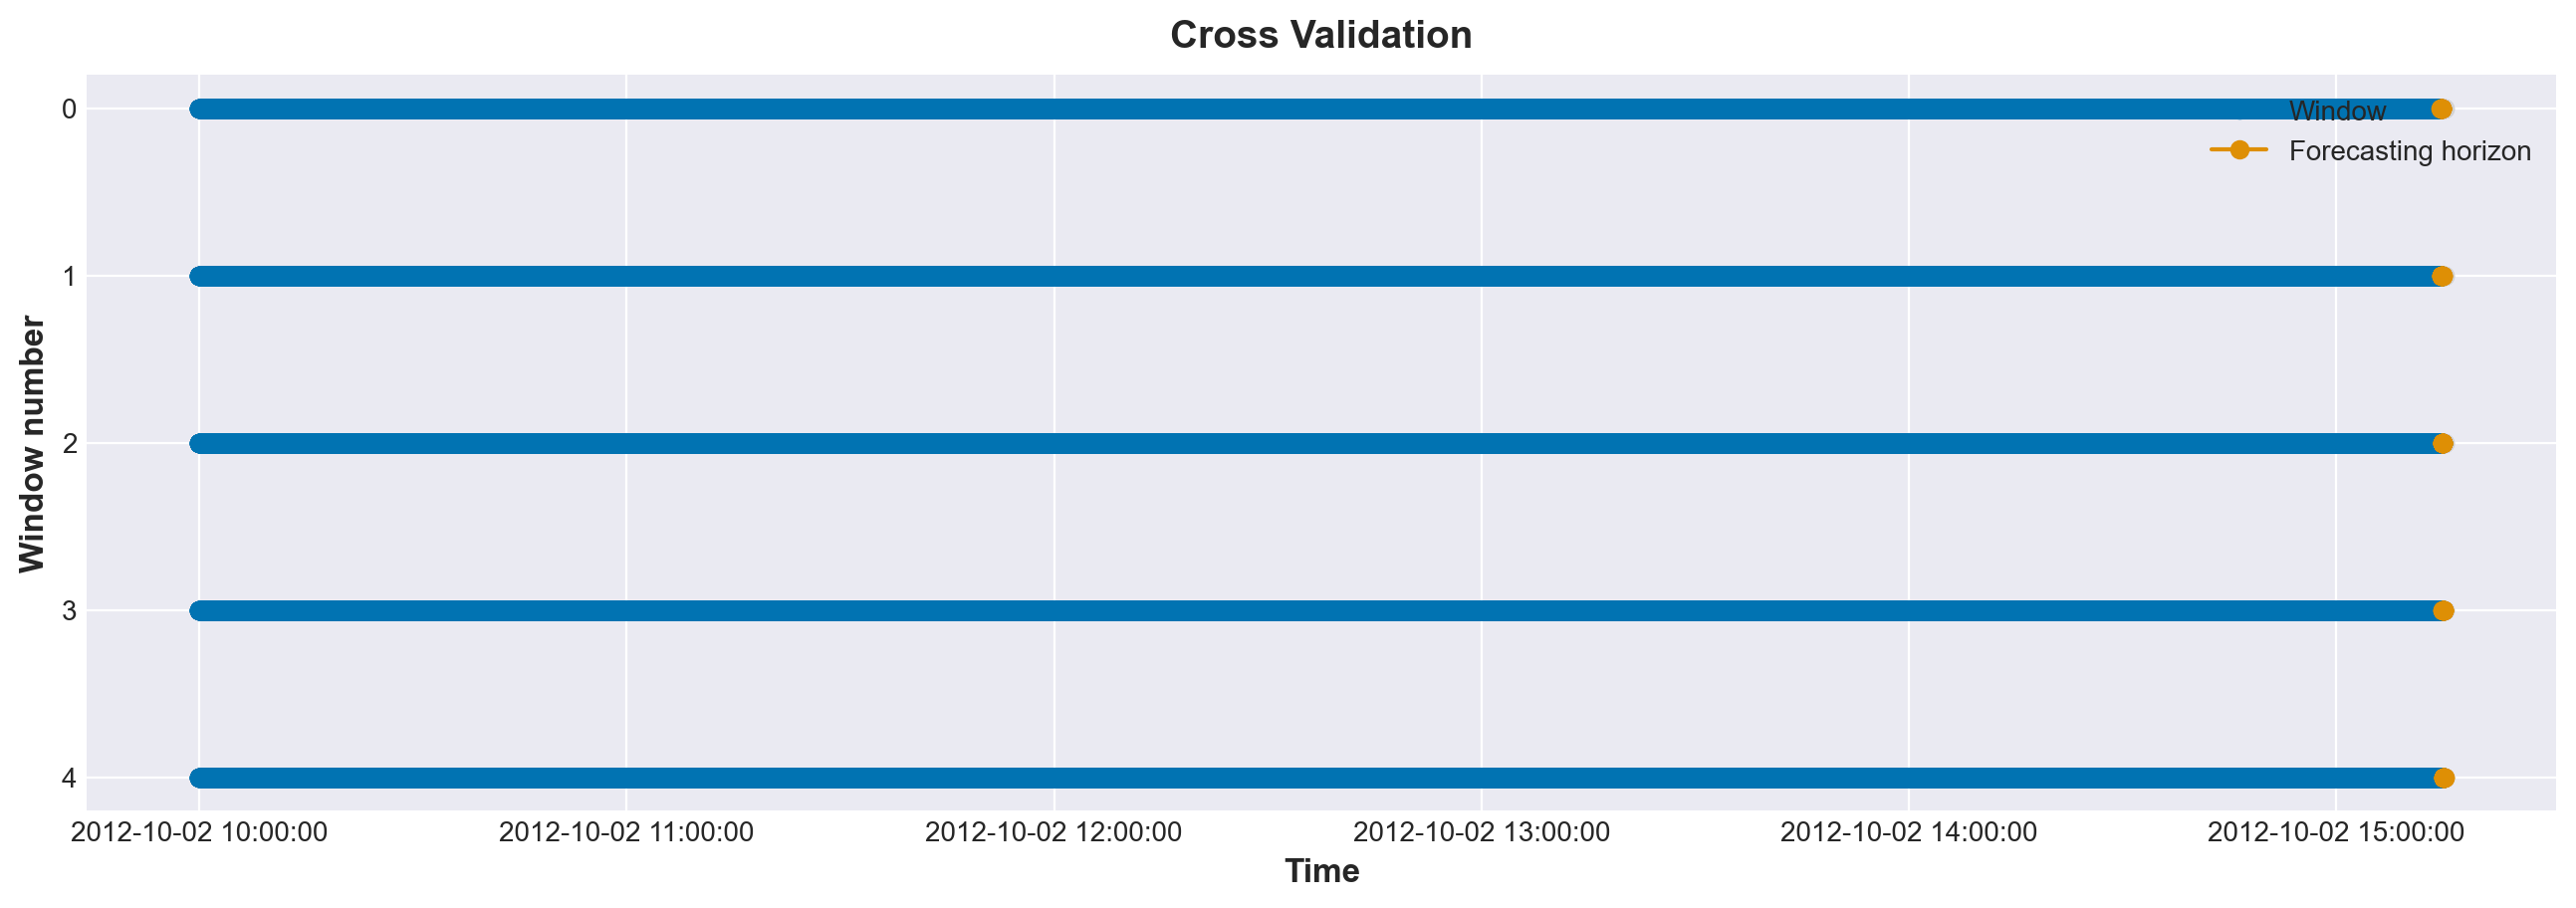

In [7]:
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
)
from sktime.utils.plotting import plot_windows

fh = np.arange(1, TEST_SIZE + 1)

y_size = len(y_train)

fold = 5

step_length = len(fh)

fh_max_length = max(fh)

intital_window_size = y_size - ((fold - 1) * step_length + 1 * fh_max_length)

# intital_window_size = int(y_train.shape[0] * 0.80)

print(
    f"intital_window_size {intital_window_size} , step_length {step_length} for fold {fold}"
)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

plot_windows(cv, y_train, title="Cross Validation")

In [8]:
%%time

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import HuberRegressor

from sktime.forecasting.compose import (
    ForecastingPipeline,
    make_reduction,
    TransformedTargetForecaster,
)
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.compose import OptionalPassthrough
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.detrend import (
    Detrender,
    Deseasonalizer,
    ConditionalDeseasonalizer,
)
from sktime.forecasting.trend import PolynomialTrendForecaster

from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanAbsoluteError

param_grid = {
    # "forecaster__deseasonalizer__model": ["additive", "multiplicative"],
    "scaler_x__passthrough": [True],
    "forecaster__deseasonalizer__model": ["additive"],
    "forecaster__deseasonalizer__sp": [24],
    "forecaster__detrender__forecaster__degree": [1, 2],
    "forecaster__reducer__window_length": [24],
    "forecaster__reducer__estimator__epsilon": [1, 1.5, 1.9],
    "forecaster__reducer__estimator__alpha": [
        0.0000001,
        0.000001,
        0.00001,
        0.0001,
        0.001,
        0.01,
        0.1,
        0.9,
    ],
}

forecaster_pipe = ForecastingPipeline(
    steps=[
        (
            "x_transforner",
            TransformerPipeline(
                steps=[("imputer_x", Imputer(method="ffill", random_state=80))]
            ),
        ),
        (
            "scaler_x",
            OptionalPassthrough(
                TabularToSeriesAdaptor(MinMaxScaler()), passthrough=False
            ),
        ),
        (
            "forecaster",
            TransformedTargetForecaster(
                steps=[
                    ("imputer_y", Imputer(method="ffill", random_state=80)),
                    (
                        "deseasonalizer",
                        ConditionalDeseasonalizer(model="additive", sp=24),
                    ),
                    (
                        "detrender",
                        Detrender(forecaster=PolynomialTrendForecaster(degree=1)),
                    ),
                    (
                        "reducer",
                        make_reduction(
                            estimator=HuberRegressor(),
                            scitype="tabular-regressor",
                            window_length=10,
                            strategy="recursive",
                            pooling="global",
                        ),
                    ),
                ]
            ),
        ),
    ]
)

fh = np.arange(1, TEST_SIZE + 1)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

print(f"Number of CPU Count:   {os.cpu_count()}")

n_cpu = os.cpu_count() - 1 if os.cpu_count() > 2 else 1

gscv = ForecastingGridSearchCV(
    forecaster_pipe,
    strategy="refit",
    scoring=MeanAbsoluteError(),
    cv=cv,
    param_grid=param_grid,
    verbose=10,
    n_jobs=n_cpu,
    refit=True,
    error_score="raise",
)

gscv.fit(y_train, X=x_train, fh=fh)

print("Best Params", gscv.best_params_)
print("Best scores", gscv.best_score_)
# print('Best Params', gscv.best_forecaster_)

Number of CPU Count:   12
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params {'forecaster__deseasonalizer__model': 'additive', 'forecaster__deseasonalizer__sp': 24, 'forecaster__detrender__forecaster__degree': 1, 'forecaster__reducer__estimator__alpha': 0.1, 'forecaster__reducer__estimator__epsilon': 1.5, 'forecaster__reducer__window_length': 10, 'scaler_x__passthrough': True}
Best scores 573.0795346992187
CPU times: total: 828 ms
Wall time: 1min 9s


In [9]:
print(x_test.columns)

Index(['temp', 'rain_1h', 'snow_1h', 'clouds_all'], dtype='object')


2018-09-29 18:00:00    4323.527085
2018-09-29 19:00:00    3676.909251
2018-09-29 20:00:00    3330.422799
2018-09-29 21:00:00    3108.784201
2018-09-29 22:00:00    2624.187199
2018-09-29 23:00:00    1944.251308
2018-09-30 00:00:00    1327.646806
2018-09-30 01:00:00    1028.241646
2018-09-30 02:00:00     978.940941
2018-09-30 03:00:00    1032.230391
2018-09-30 04:00:00    1352.949976
2018-09-30 05:00:00    2511.687022
2018-09-30 06:00:00    4057.348572
2018-09-30 07:00:00    4467.624835
2018-09-30 08:00:00    4283.594656
Freq: H, Name: traffic_volume, dtype: float64

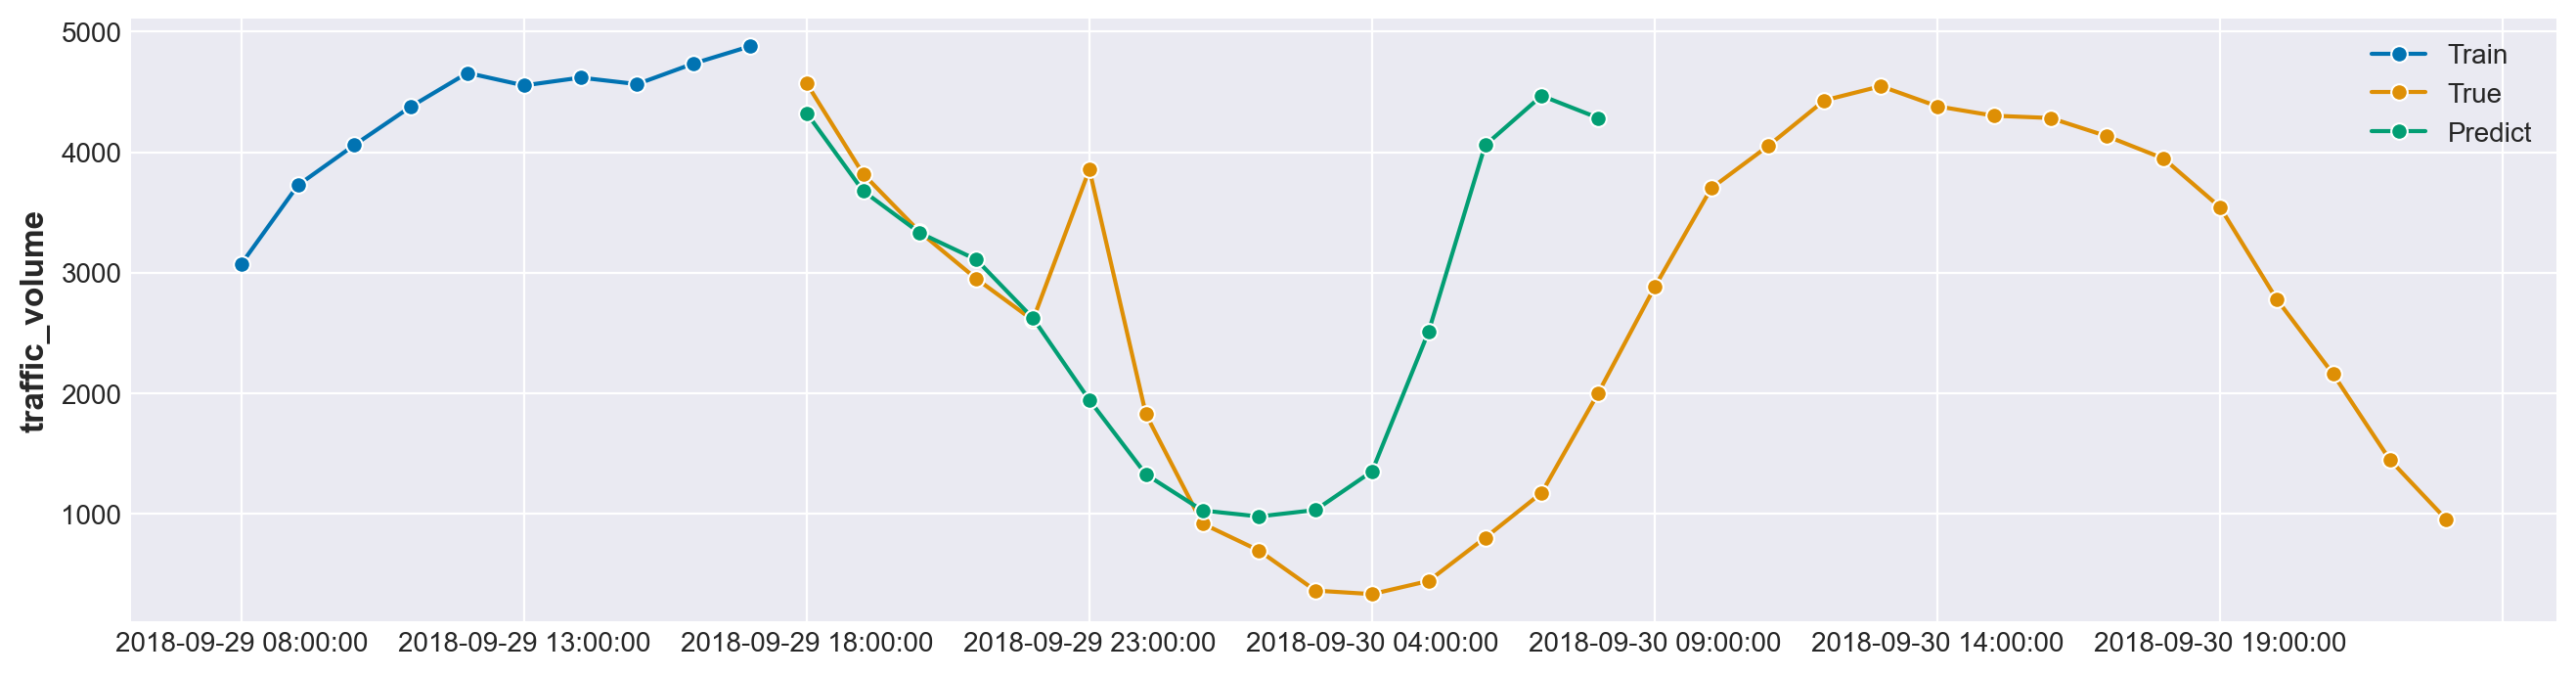

In [10]:
y_predict = gscv.predict(fh=fh, X=x_test)
plot_series(y_train.tail(10), y_test, y_predict, labels=["Train", "True", "Predict"])
y_predict

In [ ]:
print(gscv.cv_results_.shape)
gscv.cv_results_.head()

### Backtesting Insample Prediction

In [ ]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    MeanSquaredError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanAbsoluteScaledError,
)

losses = [
    MeanSquaredError(),
    MeanSquaredError(square_root=True),
    MeanAbsoluteError(),
    MeanAbsolutePercentageError(),
    MeanAbsolutePercentageError(symmetric=False),
    MeanAbsoluteScaledError(),
]

results = evaluate(
    forecaster=gscv.best_forecaster_,
    y=y_train,
    X=x_train,
    cv=cv,
    scoring=losses,
    return_data=True,
)
results

In [ ]:
plot_series(
    y_train.tail(100),
    *results["y_pred"].to_list(),
    labels=["y_pred"] + [f"y_pred_{i}" for i in results.index],
)

### Get best model Parameters

In [ ]:
gscv.best_forecaster_.get_fitted_params()

### Train Model Parameter

In [ ]:
model_n_features_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__n_features_in"
]
model_fname_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__feature_names_in"
]
model_coeff = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__coef"
]
model_intercept = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__intercept"
]

print(f"model_n_features_in {model_n_features_in}", end="\n\n")
print(f"model_fname_in {model_fname_in}", end="\n\n")
print(f"model_coeff {model_coeff}", end="\n\n")
print(f"model_intercept {model_intercept}", end="\n\n")

In [ ]:
x_train.tail()

### model cutoff

In [ ]:
print(gscv.best_forecaster_.cutoff, y_train.index[-1])

### Model Cloning

In [ ]:
from sklearn.base import clone

model = clone(gscv.best_forecaster_).set_params(**gscv.best_params_)

dir(model)

### Model saving 

In [ ]:
# gscv.best_forecaster_.save("../results/elastic_net")

import joblib

joblib.dump(gscv.best_forecaster_, "../results/HuberRegressor.pkl")

### Features importance

In [ ]:
pd.DataFrame(model_coeff, index=model_fname_in, columns=["Coeff"]).plot(
    kind="barh", alpha=0.75
)